In [2]:
import sys
sys.path.append('../_amigocloud')

In [4]:
from werkzeug.wrappers import Request, Response
from jinja2 import Template
from datetime import datetime, timedelta
import collections
from datetime import datetime
from amigocloud import AmigoCloud
import qrcode

In [6]:
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [27]:
# variables globales
id_proyecto_quema = 31874
id_dataset_quema = 292618

In [12]:
id = 156

## convertir formato de fecha

In [13]:
# convierte de formato YYYY-mm-dd H:M:S+z a d/m/YYYY
def convertir_formato_fecha(fecha):
    new_formato = datetime.strptime(fecha, "%Y-%m-%d %H:%M:%S%z").strftime("%d/%m/%Y")
    return new_formato

## ejecutar query

In [14]:
# ejecuta cualquier query sql en el proyecto que se le indique
# requiere el id de proyecto, query a ejecutar y tipo solicitud (get o post)
def ejecutar_query_sql(id_project, query, tipo_sql):
    # define la url del proyecto para ejecutar el querry
    url_proyecto_sql = f'https://app.amigocloud.com/api/v1/projects/{id_project}/sql'
    # crea la estructura de query para amigocloud
    query_sql = {'query': query}
    
    resultado_get = ''
    # eleige que tipo de solicitud se realizara (get o post)
    if tipo_sql == 'get': 
        resultado_get = amigocloud.get(url_proyecto_sql, query_sql)
    elif tipo_sql == 'post':
        resultado_get = amigocloud.post(url_proyecto_sql, query_sql)
    else:
        resultado_get = 'Se a seleccionado un tipo de solicitud erroneo.'
    return resultado_get

## ejecuta query segun id_query (ejecucion de queryes de un proyecto)

In [16]:
# ejecuta un query que esta almacenado en un proyecto de amigocloud (generalmente un update),
# requiere id de proyecto e id de query
# retorna cuantas filas fueron afectadas
def ejecutar_query_por_id(id_project, id_query):
    # obtiene el query basado en el id_project y el id_query
    get_query = amigocloud.get(f'https://app.amigocloud.com/api/v1/projects/{id_project}/queries/{id_query}')
    # se extrae solo el texto del query
    query = get_query['query']
    # ejecuta el query_sql con metodo post y guarda la respuesta
    respuesta_post = ejecutar_query_sql(id_proyecto, query, 'post')
    # retorna el numero de filas afectadas por el query
    return respuesta_post['count']

## generar qr

In [17]:
# genera un qr con datos texto que le se envie
# requiere le texto de contenido, ruta donde se guardara el qr y nombre para guardar
def generar_qr(contenido_qr, ruta_save, id_name):
    # declara obj del qrocode
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4)
    # se agrega el contenido del qr
    qr.add_data(contenido_qr)
    qr.make(fit=True)
    # define colores del qr
    img = qr.make_image(fill_color="black", back_color="white")
    # define ruta y nombre para guardar el qr
    ruta_qr = ruta_save + id_name + '.png'
    # guardar el código QR en un archivo .png
    img.save(ruta_qr)
    # retorna la ruta del qr
    return ruta_qr

## convertir un dict a obj

In [18]:
# convierte un dict a un obj
# recibe el dict y el nombre con el que se creara el obj
def convertir_dict_obj(diccionario, name):
    return collections.namedtuple(name, diccionario.keys())(*diccionario.values())

## buscar fotos

In [20]:
# busca las fotos en una galeria determinada, y que corresponda con un id
# recibe el nombre de una galeria y el id correspondiente
def buscar_fotos(galeria, source_id):
    # se construye el query
    query_sql = f"select * from {galeria} where source_amigo_id='{source_id}'"
    # se ejecuta el query con un metodo get
    respuesta = ejecutar_query_sql(id_proyecto, query_sql, 'get')
    # retorna un json completo de las fotos encontradas
    return respuesta

## descargar la lista de fotos y convertir a inline

In [22]:
# converir img en inline
# recibe el documento sobre el que se agrega el inline, la ruta de la imagen, y en ancho de la imagen para agregar al doc
def convertir_img_to_inline(docu, filename, ancho):
    return docxtpl.InlineImage(docu, image_descriptor = filename, width=Mm(ancho))

In [23]:
# descarga las fotos, las convierte en inline
# recibe la lista de fotos (json, con estructura de galeria de amigocloud), ruta donde guardar las fotos y documento sobre el que se agrega los inline
def descargar_convertir_fotos_inline(lista_fotos, ruta_save, documento):
    # crea lista vacia para acumular las fotos inline
    lista_fotos_inline = []
    # recorre la lista de fotos (json)
    for foto in lista_fotos:
        # posos para descargar img
        response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['s3_filename'])
        file_name = ruta_save + foto['s3_filename']
        file = open(file_name, "wb")
        file.write(response.content)
        file.close()
        # convertir imagen descargada a inline
        inline_img = convertir_img_to_inline(documento, file_name, 60)
        # agrega el inline a la lista
        lista_fotos_inline.append(inline_img)
    # retorna la lista inline
    return lista_fotos_inline

## modificar reporte generado

In [25]:
# coloca en true el estado de reporte
# recibe el id del registro
def modificar_reporte_generado(id_reg):
    query = f'update dataset_341171 set informe_generado = true where id={id_reg}'
    ejecutar = ejecutar_query_sql(id_proyecto, query, 'post')
    # retorna la cantidad de registro modificados
    return ejecutar['count']

In [38]:
def verificar_registros_nuevos(id_dataset):
    #ejecutar_query_por_id(id_proyecto, 6340)
    query = f'select id from dataset_{id_dataset} where informe_generado = false'
    # ejecucion del query
    select = ejecutar_query_sql(id_proyecto_quema, query, 'get')
    # extrae la seccion de data
    data = select['data']
    # convierte data a lista de ids
    lista_ids = [dato['id'] for dato in data]
    # modificacion a la lista para que solo genere 2 ids
    return lista_ids
    #for i in lista_ids:
        #print(i)
        #generar_reporte(i)

In [40]:
ids_quemas = verificar_registros_nuevos(id_dataset_quema)
ids_quemas

[156]

In [43]:
res = ejecutar_query_por_id(id_proyecto_quema, 5078)

In [44]:
res

2

In [ ]:
for i in ids_quemas:
    generar_informe_quema(i)

## generar reporte quemas

In [32]:
def generar_informe_quema(id_insp):
    
    

In [43]:
# DATOS DE LAS INPECCION
query = {'query': 'select CURRENT_DATE, * from dataset_292618 where id = {id}'.format(id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
data = select['data'][0]
data['date'] = datetime.strptime(data['date'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_quema'] = datetime.strptime(data['fecha_quema'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_inspeccion'] = datetime.strptime(data['fecha_inspeccion'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')

insp = collections.namedtuple("insp", data.keys())(*data.values())
print('end')

end


In [44]:
insp

insp(date='23/05/2024', fecha_registro='2024-05-23 04:41:19+00:00', amigo_id='d25c20c867794b0884a2801625a11235', fecha_quema='22/05/2024', fecha_inspeccion='23/05/2024', fecha_update='2024-05-23 15:01:21.489095+00:00', canhero='12478 / SERRATE COLAMARINO HUGO', superficie_total=7.3, rendimiento=65.0, produccion=474.5, responsable='Rogelio Acuña Rodríguez', inicio_incendio='Dentro de la propiedad', causa='Quema de malojo', responsable_de_quema='PROPIO', observaciones=None, link_informe=None, link_informe_editable=None, cite=94, link_comprobante=None, id=156, tipo_cosecha='MECANIZADO')

In [45]:
# DATOS DE LA PROPIEDAD
query = {'query': 'select * from dataset_293179 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=insp.amigo_id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
propiedades_data = select['data']
print('end')

end


In [46]:
propiedades_data

[{'ubicacion': '0101000020E61000008C29FD29FA9A4FC065D30094753631C0',
  'amigo_id': '377246cd1d7f460cb1fc56b933e7e997',
  'fecha_registro': '2024-05-23 04:44:14+00:00',
  'fecha_update': '2024-05-23 14:57:02+00:00',
  'propiedad': '1215 / LA FORTUNA--HUGO SERRATE',
  'tenencia': 'Propio',
  'insp_ref_prop': 'd25c20c867794b0884a2801625a11235'}]

In [47]:
propiedades = []
for prop in propiedades_data:
    prop['lote'] = []
    query_lotes = {'query': 'select * from dataset_293180 where prop_ref_lote = \'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    lotes_select = amigocloud.get(project, query_lotes)
    for lote_select in lotes_select['data']:
        lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
        prop['lote'].append(lote)
    propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
print('end')

end


In [48]:
propiedades

[propiedad(ubicacion='0101000020E61000008C29FD29FA9A4FC065D30094753631C0', amigo_id='377246cd1d7f460cb1fc56b933e7e997', fecha_registro='2024-05-23 04:44:14+00:00', fecha_update='2024-05-23 14:57:02+00:00', propiedad='1215 / LA FORTUNA--HUGO SERRATE', tenencia='Propio', insp_ref_prop='d25c20c867794b0884a2801625a11235', lote=[lote(geometria='0106000020E610000001000000010300000001000000080000000C4C135BE69A4FC0BCD0D9B8B43431C0A3B5FD86E49A4FC06AD894D0023531C0537BC7DFAC9A4FC0A3CC17C5BC3431C06D5974A1A89A4FC01CF40071B23431C02737E565A89A4FC0A6924B2DA53431C0667C5F5CAA9A4FC00CF6155A8C3431C006BEA25BAF9A4FC0647D5E4C8E3431C00C4C135BE69A4FC0BCD0D9B8B43431C0', amigo_id='fc87ac9c884e403c916a5f0a6e60629e', fecha_registro='2024-05-23 14:55:28+00:00', fecha_update='2024-05-23 14:57:39+00:00', lote='L5', superficie=2.07, observaciones=None, prop_ref_lote='377246cd1d7f460cb1fc56b933e7e997'), lote(geometria='0106000020E6100000010000000103000000010000001E000000A72AFC8EE49A4FC05ABF7C980A3531C071B81CE7DF9A4FC0D

In [49]:
# selecciona todas las fotos y nombre de lotes basado en el id de la inspeccion
query_fotos = {'query': 'select l.lote, g.s3_filename file_name from gallery_42303 g\
                            inner join dataset_293180 l on l.amigo_id = g.source_amigo_id\
                            inner join dataset_293179 p on p.amigo_id = l.prop_ref_lote\
                            inner join dataset_292618 i on i.amigo_id = p.insp_ref_prop\
                            where i.id = {src_id}'.format(src_id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query_fotos)
fotos = select['data']
fotos

[{'lote': 'L5', 'file_name': 'IMG-20240523-WA0010.jpg'},
 {'lote': 'L3', 'file_name': 'IMG-20240523-WA0009.jpg'}]

In [50]:
from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

In [51]:
ruta

'C:\\Documents\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

end


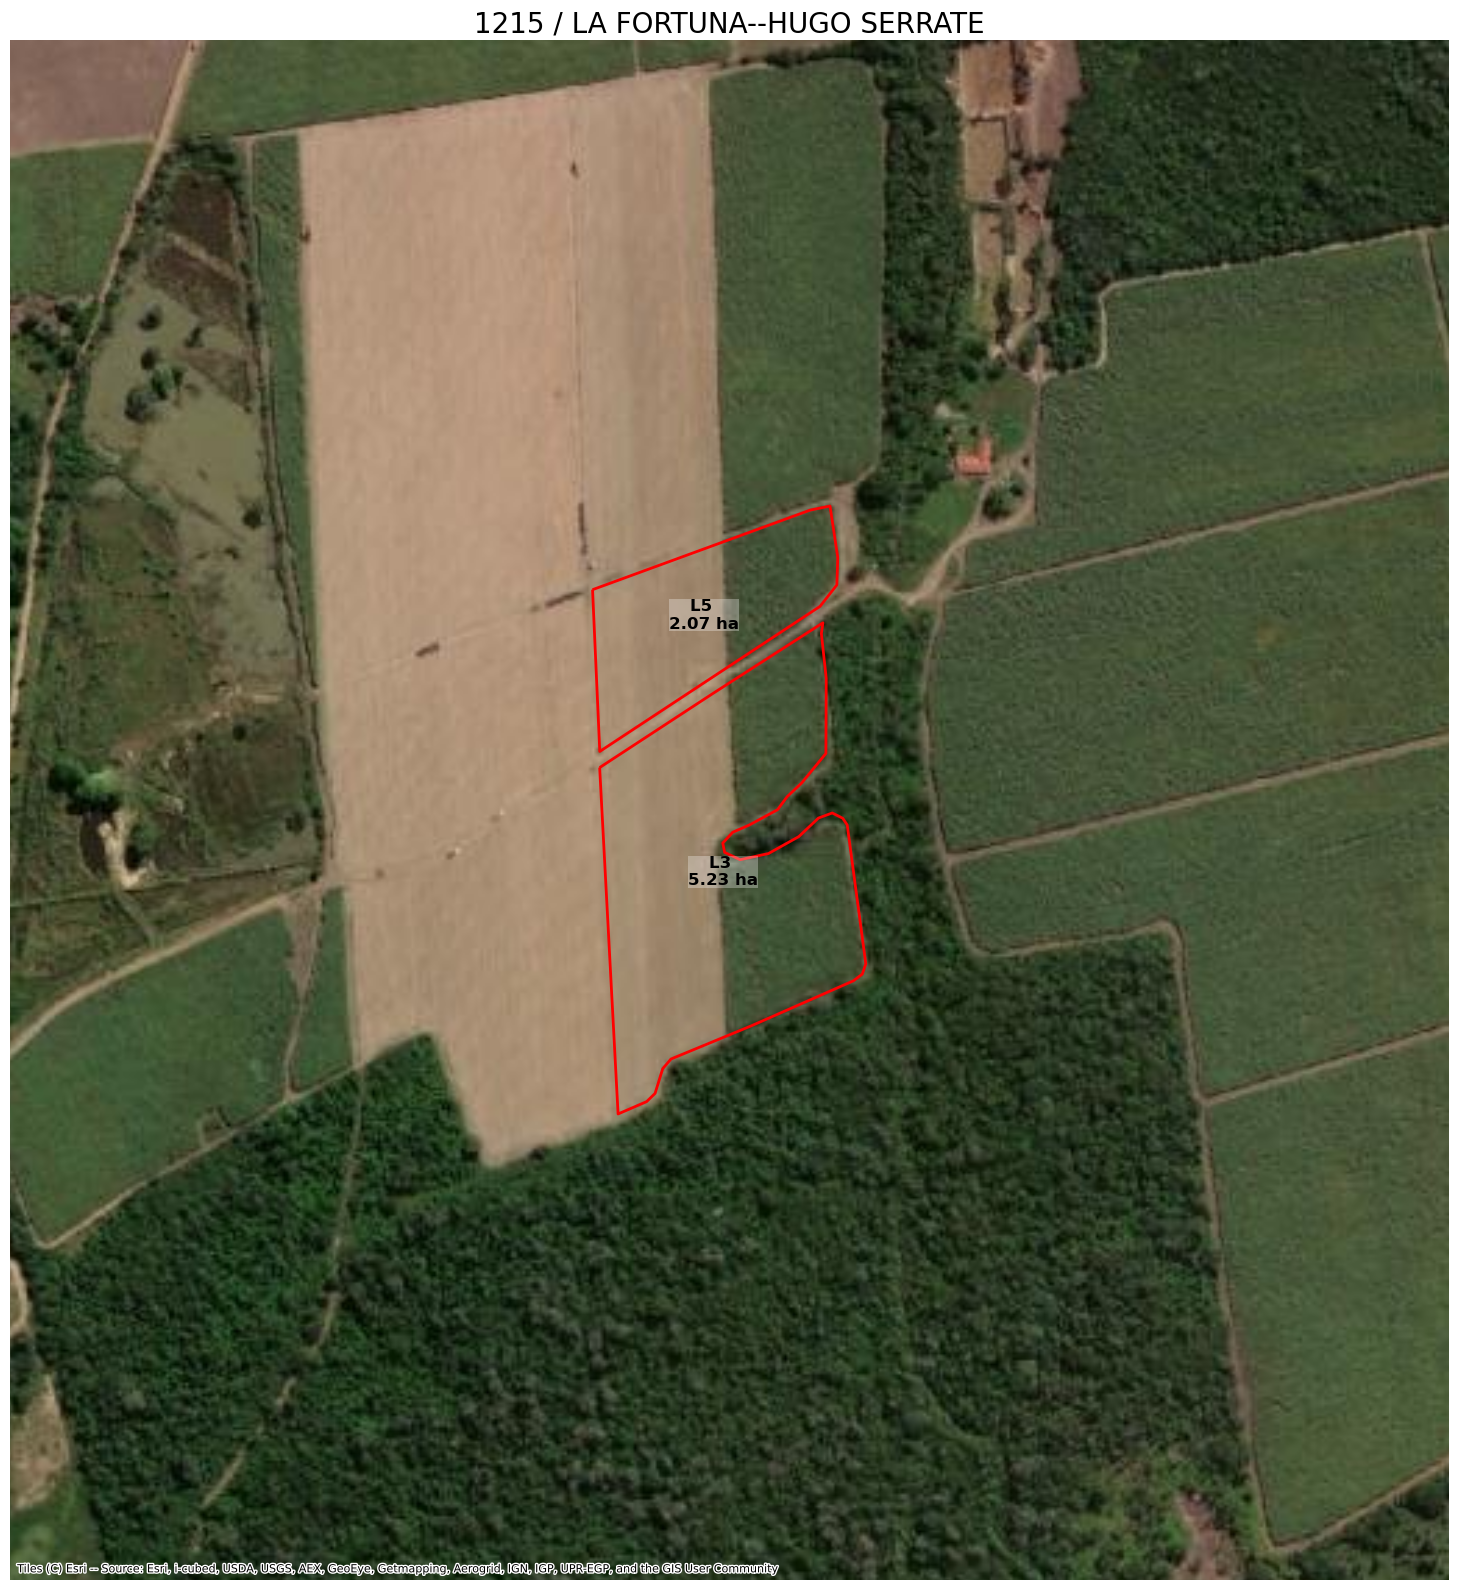

In [52]:
i = 0
lista_planos = []
path = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lote:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    path = ruta + '/planos/' + str(insp.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
    lista_planos.append(path)
    fig.savefig(path, dpi = 300, bbox_inches='tight')
    del fig
print('end')

In [53]:
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

doc = DocxTemplate(ruta + "/templates/tpl_infome_quema.docx")

#generar lista de InlineImage de planos 
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    file = open(ruta + '/fotos/' + foto['file_name'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor= ruta + '/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})

firma_respon = None
if insp.responsable == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))

context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)

# formato de nombre de archivo: "123_CQ_01-01-2022_NOMBRE"
cod_nom = insp.canhero.split(' / ')
file_name = cod_nom[0] + '_CAQ_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1] + '_' + str(insp.id)

doc.save(ruta + '/informes/_' + file_name + '.docx')